# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import random

In [2]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 3000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя
n_hidden_3 = 512 # количество нейронов 3-го слоя

In [3]:
# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 2s 0us/step


In [4]:
# Создадим нейронную сеть

class DenseLayer(tf.keras.layers.Layer):
    def __init__(self, in_features, out_features):
        super(DenseLayer, self).__init__()
        self.dense_weights = self.add_weight("dense_weights", shape=[in_features, out_features])
        self.biases = self.add_weight("biases", shape=[out_features])

    def __call__(self, x):
        return tf.matmul(x, self.dense_weights) + self.biases

class NN(tf.keras.Model):
  def __init__(self):
    super(NN, self).__init__()
    # Первый слой, состоящий из 128 нейронов
    self.layer1 = DenseLayer(num_features, n_hidden_1)

    # Второй слой, состоящий из 256 нейронов
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)

    # Третий слой, состоящий из 512 нейронов
    self.layer3 = DenseLayer(n_hidden_2, n_hidden_3)

    # Выходной слой
    self.out_layer = DenseLayer(n_hidden_3, num_classes)

    self.relu = tf.keras.layers.ReLU()
    self.dropout = tf.keras.layers.Dropout(rate=0.5)
    self.normalize = tf.keras.layers.BatchNormalization()

  def call(self, x, training=False):
    # Помните что для выхода нейронной сети мы применяем к выходу функцию softmax.
    # Делаем мы это для того, чтобы
    # выход нейронной сети принимал значения от 0 до 1 в соответствии с вероятностью
    # принадлежности входного объекта к одному из 10 классов

    x = self.normalize(x, training=training)
    x = self.layer1(x)
    x = self.relu(x)
    x = self.dropout(x, training=training)
    x = self.layer2(x)
    x = self.relu(x)
    x = self.dropout(x, training=training)
    x = self.layer3(x)
    x = self.relu(x)
    x = self.out_layer(x)
    return tf.nn.softmax(x)

In [5]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Вычисление кросс-энтропии
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# В качестве метрики качества используем точность
def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [6]:
# Создадим экзампляр нейронной сети
neural_net = NN()

optimizer = tf.optimizers.Adam(learning_rate)


# Функция обучения нейросети
def train(nn, input_x, output_y):

  # Активация автоматического дифференцирования
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Создадим оптимизируемых список параметров
    trainable_variables = neural_net.trainable_variables

    # Вычислим по ним значение градиента
    gradients = g.gradient(loss, trainable_variables)

    # Модифицируем параметры
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [7]:
# Тренировка сети

loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети

# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Обновляем веса нейронной сети
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0 or step == 1:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss.numpy())
        accuracy_history.append(acc.numpy())
        print(f"Step: {step}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")

Step: 1, Loss: 570.4044, Accuracy: 0.2305
Step: 100, Loss: 48.9171, Accuracy: 0.9609
Step: 200, Loss: 38.2994, Accuracy: 0.9492
Step: 300, Loss: 18.6362, Accuracy: 0.9766
Step: 400, Loss: 31.5879, Accuracy: 0.9609
Step: 500, Loss: 13.8706, Accuracy: 0.9883
Step: 600, Loss: 15.1995, Accuracy: 0.9727
Step: 700, Loss: 18.1705, Accuracy: 0.9844
Step: 800, Loss: 10.3574, Accuracy: 0.9844
Step: 900, Loss: 8.4320, Accuracy: 0.9961
Step: 1000, Loss: 5.2244, Accuracy: 1.0000
Step: 1100, Loss: 18.2754, Accuracy: 0.9766
Step: 1200, Loss: 2.8066, Accuracy: 0.9961
Step: 1300, Loss: 18.1709, Accuracy: 0.9883
Step: 1400, Loss: 5.4113, Accuracy: 0.9922
Step: 1500, Loss: 9.0870, Accuracy: 0.9922
Step: 1600, Loss: 7.3696, Accuracy: 0.9883
Step: 1700, Loss: 3.3458, Accuracy: 0.9961
Step: 1800, Loss: 0.6924, Accuracy: 1.0000
Step: 1900, Loss: 2.4348, Accuracy: 1.0000
Step: 2000, Loss: 1.2808, Accuracy: 1.0000
Step: 2100, Loss: 3.9435, Accuracy: 0.9922
Step: 2200, Loss: 4.4336, Accuracy: 0.9922
Step: 2300,

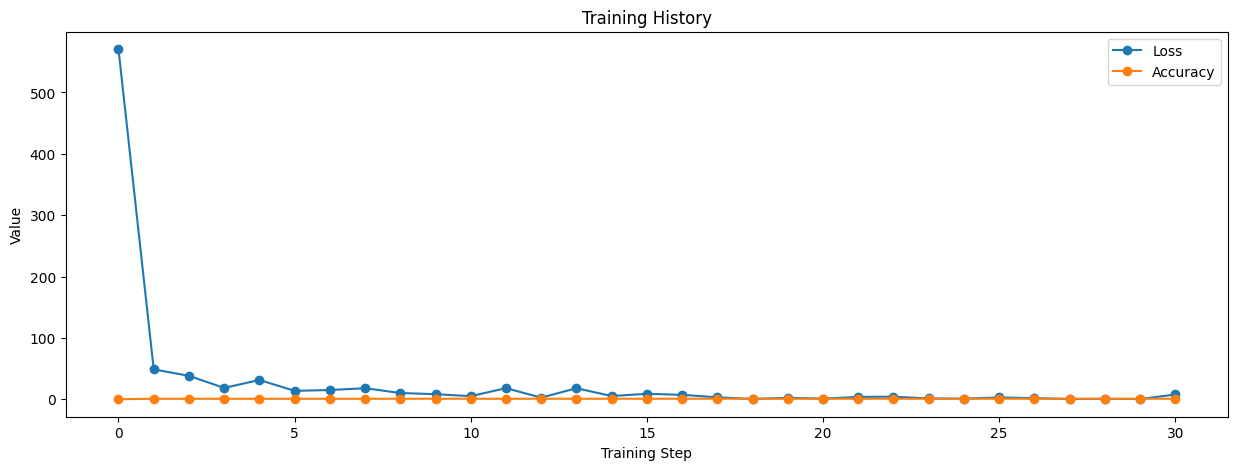

In [16]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться
plt.figure(figsize=(15, 5))
plt.plot(loss_history, label='Loss', marker='o')
plt.plot(accuracy_history, label='Accuracy',  marker='o')
plt.xlabel('Training Step')
plt.ylabel('Value')
plt.title('Training History')
plt.legend(loc='upper right')
plt.show()

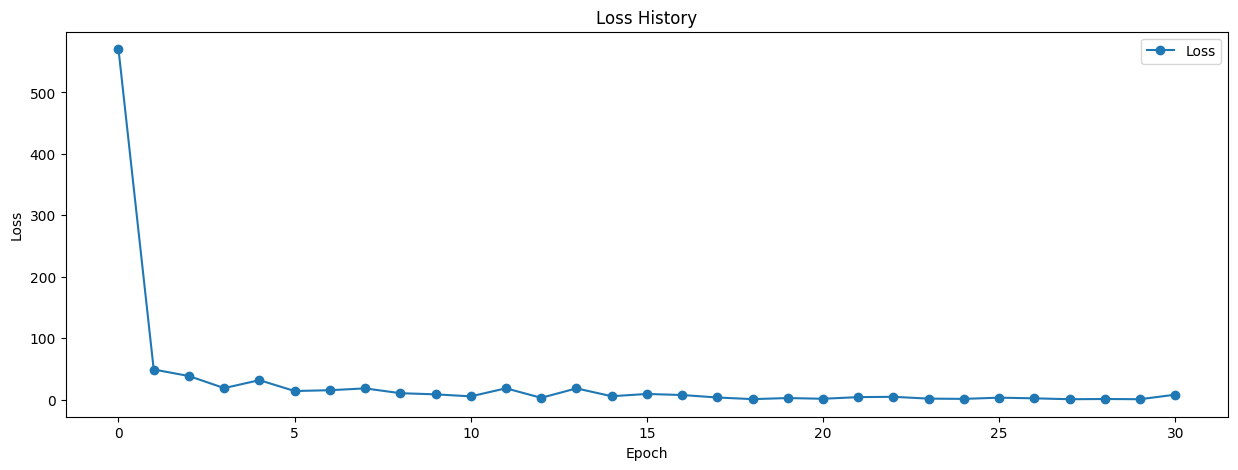

In [17]:
plt.figure(figsize=(15, 5))
plt.plot(loss_history, label='Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss History')
plt.legend()
plt.show()

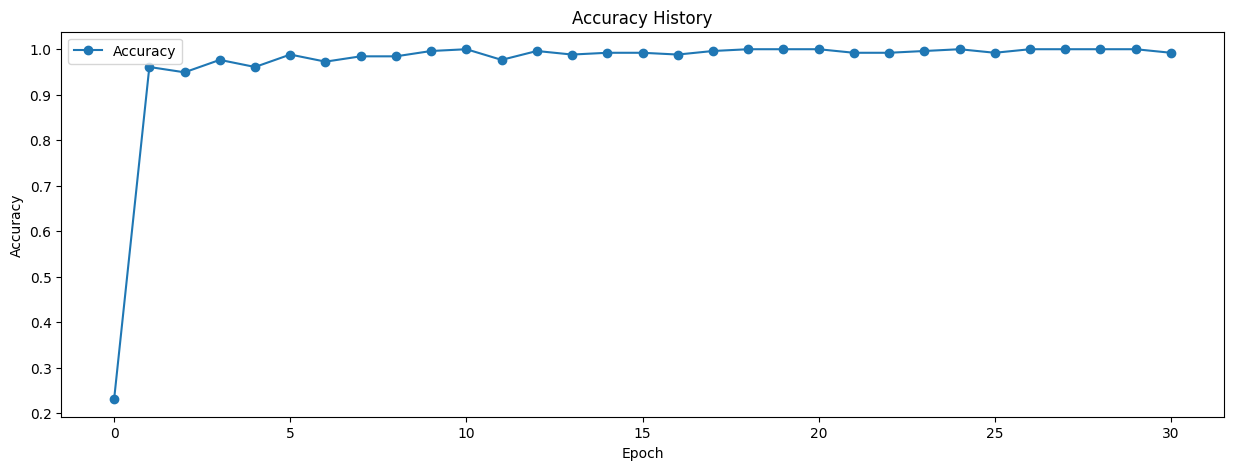

In [19]:
plt.figure(figsize=(15, 5))
plt.plot(accuracy_history, label='Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy History')
plt.legend()
plt.show()

In [9]:
# Вычислите точность обученной нейросети

pred_test = neural_net(x_test)
test_acc = accuracy(pred_test, y_test)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

Test Accuracy: 97.57%


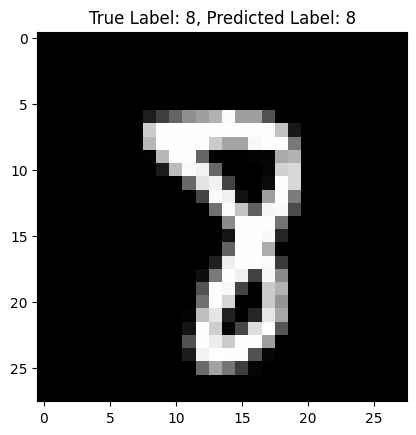

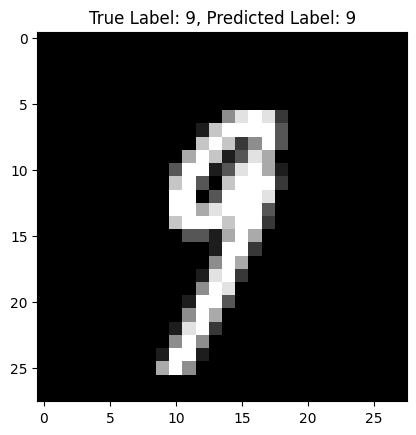

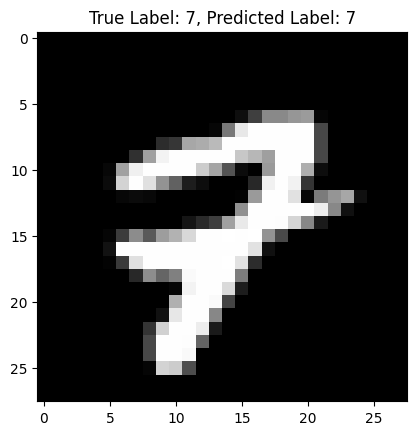

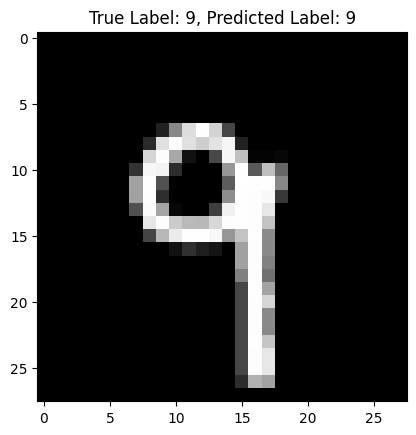

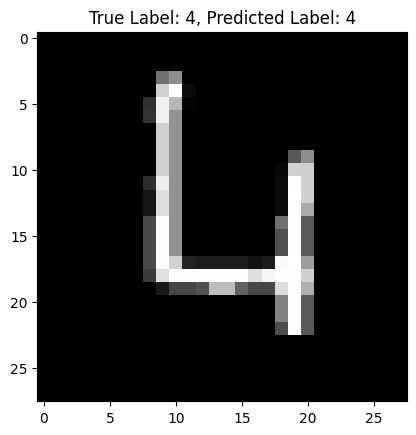

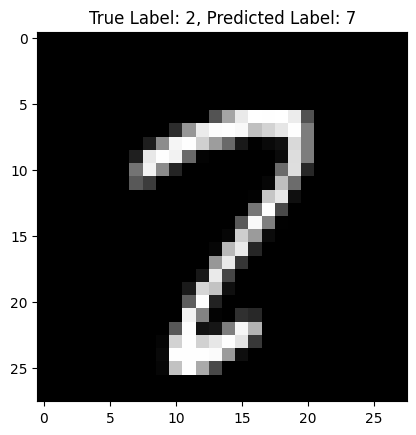

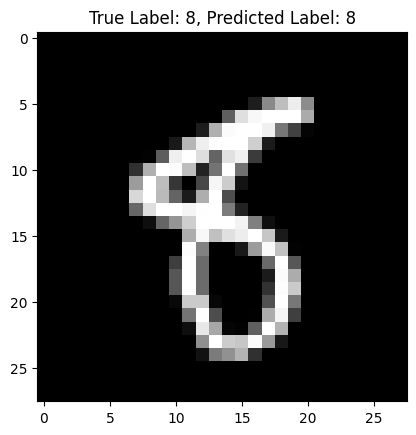

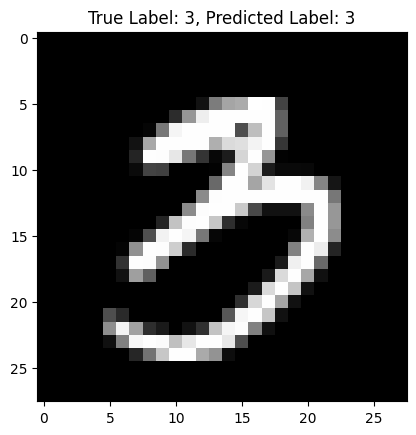

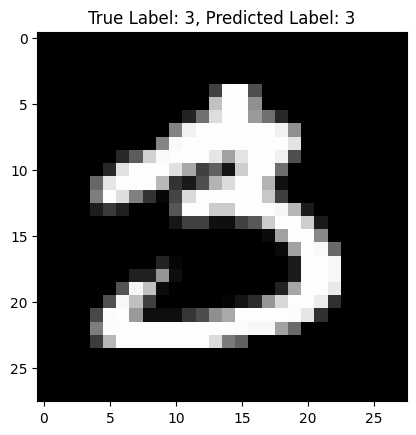

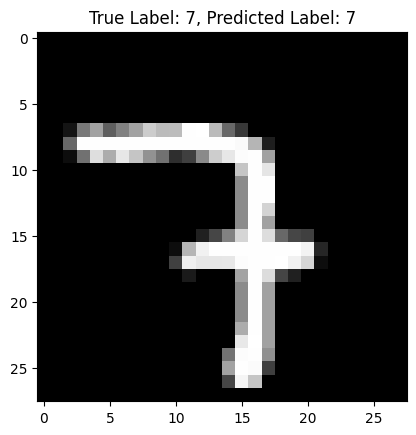

In [10]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5
# случайных изображений и передайте их в нейронню сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?

n_images = 10
random_indices = random.sample(range(len(x_test)), n_images)
test_images = x_test[random_indices]
test_labels = y_test[random_indices]
predictions = neural_net(test_images)

for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.title(f'True Label: {test_labels[i]}, Predicted Label: {np.argmax(predictions.numpy()[i])}')
    plt.show()

# Висновок

В результаті додавання третього шару нейронів, моделі вдалося досягти точності понад 97%.